In [11]:
import tensorflow as tf
from tensorflow.keras import Input, models, layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

: 

In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(dataset)

645

In [23]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


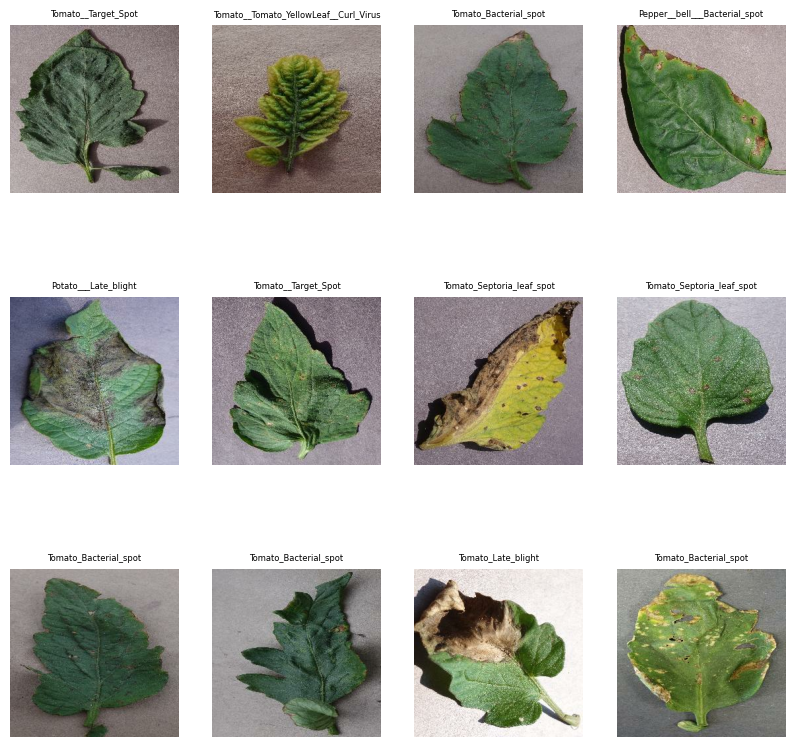

In [25]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]], fontsize=6)
    

In [15]:
len(dataset)

645

In [27]:
def get_dataset_partitions_tf(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 7)

    train_size = int(train_split * ds_size)
    validation_size = int(validation_split * ds_size)

    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(validation_size)
    test_ds = ds.skip(train_size).skip(validation_size)
    
    return train_ds, validation_ds, test_ds

In [29]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

516

In [23]:
len(validation_ds)

64

In [25]:
len(test_ds)

65

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.Rescaling(1.0/255)
])

In [35]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [37]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build()

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,527 (720.81 KB)

 Trainable params: 184,527 (720.81 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(
   optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validation_ds
)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 948s 2s/step - accuracy: 0.2311 - loss: 2.3122 - val_accuracy: 0.4591 - val_loss: 1.6406
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.5107 - loss: 1.4552 - val_accuracy: 0.4921 - val_loss: 1.7574
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 861s 2s/step - accuracy: 0.6801 - loss: 0.9314 - val_accuracy: 0.6717 - val_loss: 0.9851
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - accuracy: 0.7335 - loss: 0.7503 - val_accuracy: 0.6833 - val_loss: 0.9437
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 862s 2s/step - accuracy: 0.7880 - loss: 0.6088 - val_accuracy: 0.6549 - val_loss: 1.2643
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.8169 - loss: 0.5448 - val_accuracy: 0.7766 - val_loss: 0.6572
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 854s 2s/step - accuracy: 0.8329 - loss: 0.4761 - val_accuracy: 0.8389 - val_loss: 0.4475
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.8467 - loss: 0.4445 - val_accu

In [43]:
scores=model.evaluate(test_ds)
scores

516/516 ━━━━━━━━━━━━━━━━━━━━ 176s 341ms/step - accuracy: 0.9665 - loss: 0.0940


[0.09643781185150146, 0.9654148817062378]

first image to predict
actual label: Tomato_Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
predicted label: Tomato_Bacterial_spot


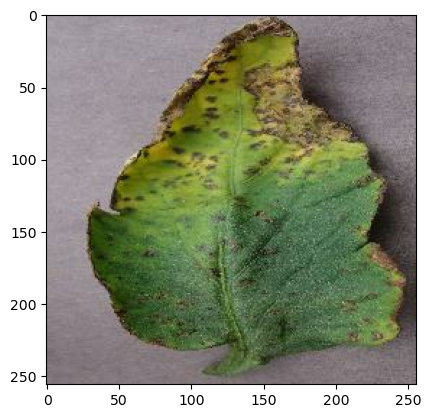

In [69]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

In [91]:
model_version = 1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


Saved artifact at '../models/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  2461804447696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804451728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804453840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804454032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804454224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804456528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804456144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804456912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804456336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804457296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2461804457104: TensorSpec(shape=(), dt

In [97]:
model.save('../models/model.keras')

In [ ]:
model = load_model('../models/model.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %.2f KBs.' % float_model_size)

INFO:tensorflow:Assets written to: C:\Users\ampho\AppData\Local\Temp\tmpppzw4jv2\assets


INFO:tensorflow:Assets written to: C:\Users\ampho\AppData\Local\Temp\tmpppzw4jv2\assets


Saved artifact at 'C:\Users\ampho\AppData\Local\Temp\tmpppzw4jv2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  2589978593232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978601680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978602448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978602640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978604560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978605136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25899

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: C:\Users\ampho\AppData\Local\Temp\tmp7p3ayitj\assets


INFO:tensorflow:Assets written to: C:\Users\ampho\AppData\Local\Temp\tmp7p3ayitj\assets


Saved artifact at 'C:\Users\ampho\AppData\Local\Temp\tmp7p3ayitj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  2589978593232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978601680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978602448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978603792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978602640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978604368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978604560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2589978605136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25899